In [473]:
import pandas as pd

# Läs in CSV-filen (byt sökväg vid behov)
df = pd.read_csv("imdb_top_1000.csv")

# Behåll bara relevanta kolumner
df = df[['Series_Title', 'Released_Year', 'Runtime', 'Genre', 'IMDB_Rating']]

df['Runtime'] = df['Runtime'].str.replace(' min', '', regex=False)
df['Runtime'] = pd.to_numeric(df['Runtime'], errors='coerce')
df['Released_Year'] = df['Released_Year'].str.extract('(\d{4})').astype(float)
df['Main_Genre'] = df['Genre'].str.split(',').str[0].str.strip()
df.dropna(inplace=True)
df.describe()


<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
C:\Users\albin\AppData\Local\Temp\ipykernel_96396\66903748.py:11: SyntaxWarning: invalid escape sequence '\d'
  df['Released_Year'] = df['Released_Year'].str.extract('(\d{4})').astype(float)


,Released_Year,Runtime,IMDB_Rating
count,999.000000,999.000000,999.000000
mean,1991.217217,122.873874,7.949650
std,23.297025,28.102520,0.275407
min,1920.000000,45.000000,7.600000
25%,1976.000000,103.000000,7.700000
50%,1999.000000,119.000000,7.900000
75%,2009.000000,137.000000,8.100000
max,2020.000000,321.000000,9.300000


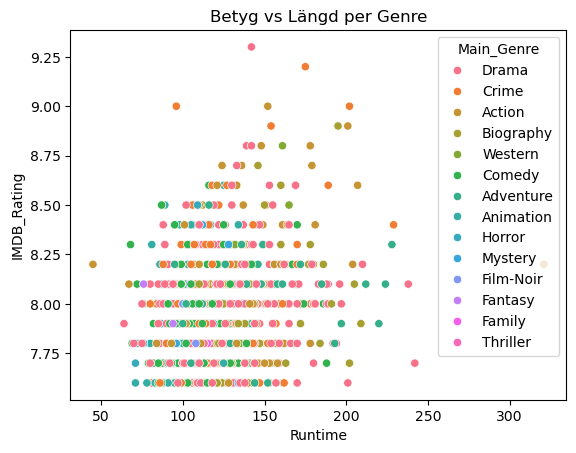

In [474]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x='Runtime', y='IMDB_Rating', hue='Main_Genre')
plt.title("Betyg vs Längd per Genre")
plt.show()


In [475]:
from sklearn.preprocessing import StandardScaler

# Numeriska features
features = df[['Released_Year', 'Runtime', 'IMDB_Rating']]

# One hot encoding av Main_Genre
genre_dummies = pd.get_dummies(df['Main_Genre'])

# Kombinera
X = pd.concat([features, genre_dummies], axis=1)

# Standardisera
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [476]:
import seaborn as sns
import matplotlib.pyplot as plt

# Välj två originalfeatures för att plotta
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Runtime", y="IMDB_Rating", hue="Cluster_raw", palette="tab10", s=50)
plt.title("K-means klustring utan PCA (Runtime vs IMDB_Rating)")
plt.xlabel("Runtime (minuter)")
plt.ylabel("IMDB Rating")
plt.legend(title="Kluster")
plt.tight_layout()
plt.show()


ValueError: Could not interpret value `Cluster_raw` for `hue`. An entry with this name does not appear in `data`.

<Figure size 800x600 with 0 Axes>

📏 Silhouette Score (PCA + KMeans, k=4): 0.230


C:\Users\albin\AppData\Local\Temp\ipykernel_96396\3669686354.py:24: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\albin\anaconda3\envs\condavenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


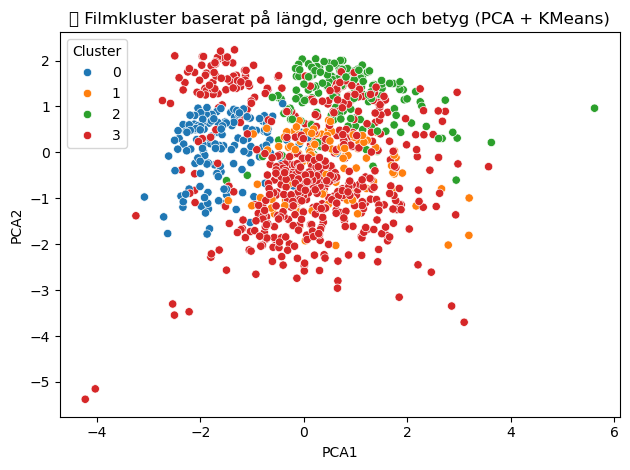

In [477]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. KMeans på skalad data
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# 2. PCA för att visualisera i 2D
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
df['PCA1'] = components[:, 0]
df['PCA2'] = components[:, 1]

# 3. Silhouette Score
score = silhouette_score(X_scaled, df['Cluster'])
print(f"📏 Silhouette Score (PCA + KMeans, k=4): {score:.3f}")

# 4. Plot
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='tab10')
plt.title("🎬 Filmkluster baserat på längd, genre och betyg (PCA + KMeans)")
plt.tight_layout()
plt.show()


c:\Users\albin\anaconda3\envs\condavenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\albin\anaconda3\envs\condavenv\Lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\albin\anaconda3\envs\condavenv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


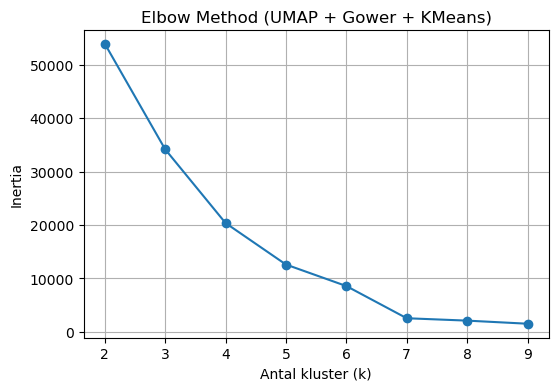

In [ ]:
import gower
import matplotlib.pyplot as plt
from umap.umap_ import UMAP
from sklearn.cluster import KMeans

# === Gower + UMAP ===
X_gower = gower.gower_matrix(df[['Runtime', 'Released_Year', 'IMDB_Rating', 'Main_Genre']])
umap_model = UMAP(metric='precomputed', random_state=42)
embedding = umap_model.fit_transform(X_gower)
df['UMAP1'] = embedding[:, 0]
df['UMAP2'] = embedding[:, 1]

# === Elbow (Inertia) ===
inertias = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embedding)
    inertias.append(kmeans.inertia_)

# === Plot Elbow ===
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Method (UMAP + Gower + KMeans)")
plt.xlabel("Antal kluster (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


📏 Silhouette Score (UMAP + KMeans, k=4): 0.618


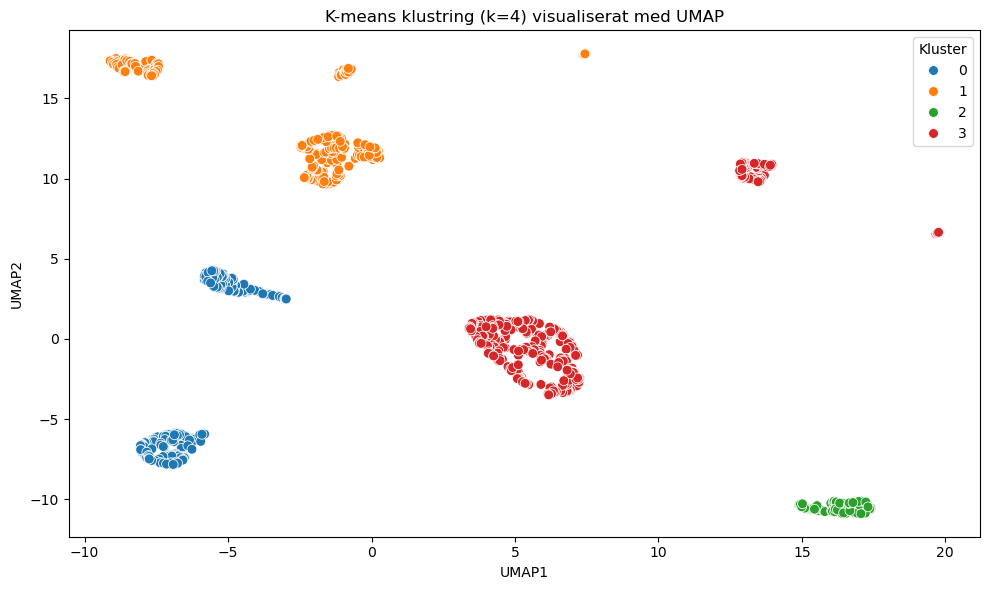

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Lägg till UMAP-komponenter i df om du inte redan gjort det
df[["UMAP1", "UMAP2"]] = X_umap

# KMeans med valt antal kluster (t.ex. k=4)
k = 4  # <-- byt till det värde du vill testa
kmeans_umap = KMeans(n_clusters=k, random_state=42)
df["Cluster"] = kmeans_umap.fit_predict(X_umap)

# Silhouette Score
score = silhouette_score(X_umap, df["Cluster"])
print(f"📏 Silhouette Score (UMAP + KMeans, k={k}): {score:.3f}")

# Rita UMAP-plot med klusterfärg
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="Cluster", palette="tab10", s=50)
plt.title(f"K-means klustring (k={k}) visualiserat med UMAP")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title="Kluster")
plt.tight_layout()
plt.show()


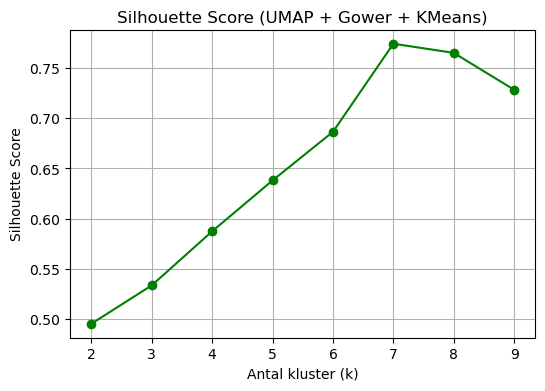

In [ ]:
from sklearn.metrics import silhouette_score

# === Silhouette Score ===
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(embedding)
    silhouette_scores.append(silhouette_score(embedding, labels))

# === Plot Silhouette ===
plt.figure(figsize=(6, 4))
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score (UMAP + Gower + KMeans)")
plt.xlabel("Antal kluster (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


📏 Silhouette Score för k=7: 0.775


C:\Users\albin\AppData\Local\Temp\ipykernel_96396\558502871.py:36: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\albin\anaconda3\envs\condavenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


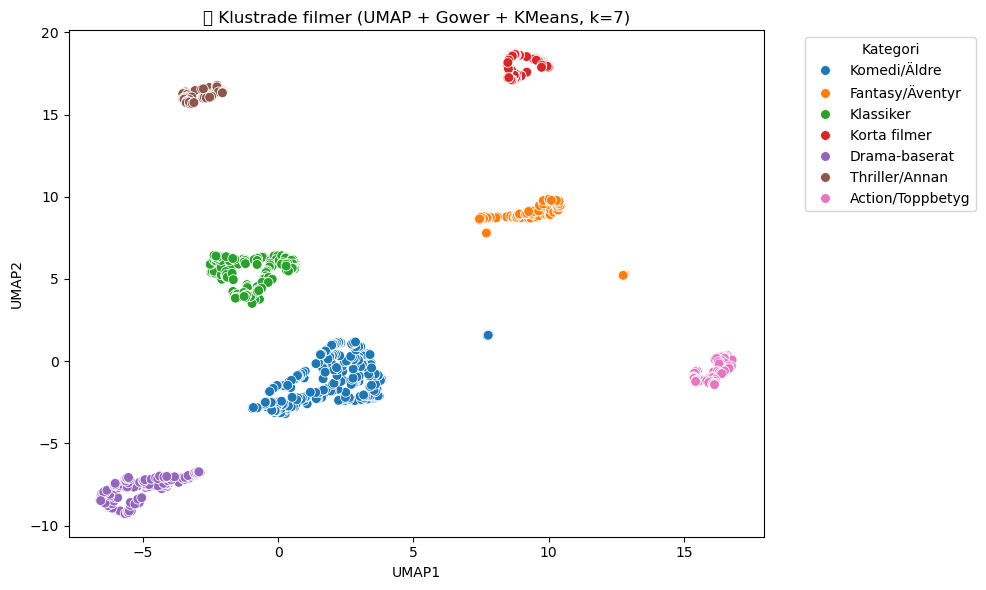

In [479]:
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# === Kontroll: Se till att UMAP1 och UMAP2 finns i df ===
df["UMAP1"] = embedding[:, 0]
df["UMAP2"] = embedding[:, 1]

# === Välj antal kluster och kör KMeans ===
k_best = 7
kmeans = KMeans(n_clusters=k_best, random_state=42)
df["Cluster"] = kmeans.fit_predict(embedding)

# === Lägg till kategorinamn (förklarande etiketter)
kategori_namn = {
    0: "Drama-baserat",
    1: "Klassiker",
    2: "Action/Toppbetyg",
    3: "Komedi/Äldre",
    4: "Fantasy/Äventyr",
    5: "Korta filmer",
    6: "Thriller/Annan"
}
df["Kategori"] = df["Cluster"].map(kategori_namn)

# === Beräkna Silhouette Score
score = silhouette_score(embedding, df["Cluster"])
print(f"📏 Silhouette Score för k={k_best}: {score:.3f}")

# === Visualisera kluster med kategorinamn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="Kategori", palette="tab10", s=50)
plt.title(f"🎬 Klustrade filmer (UMAP + Gower + KMeans, k={k_best})")
plt.legend(title="Kategori", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


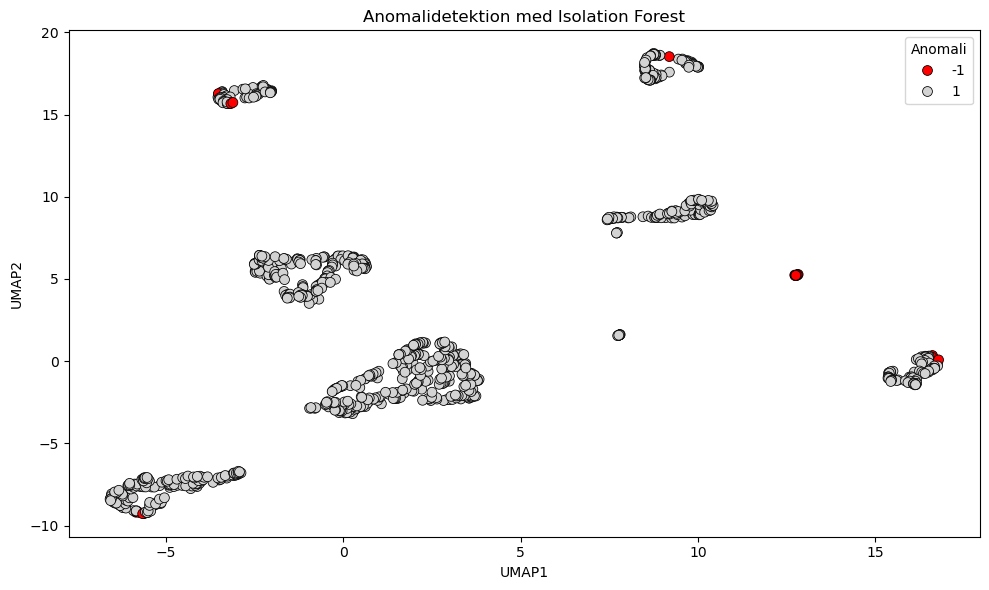

In [ ]:
from sklearn.ensemble import IsolationForest

# === 1. Isolation Forest ===
iso = IsolationForest(contamination=0.03, random_state=42)
df['Anomali'] = iso.fit_predict(embedding)  # -1 = anomalier, 1 = normal

# === 2. Visualisering i UMAP-plot ===
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='UMAP1', y='UMAP2',
    hue='Anomali',
    palette={1: 'lightgrey', -1: 'red'},
    s=50,
    edgecolor='black'
)
plt.title("Anomalidetektion med Isolation Forest")
plt.legend(title="Anomali", loc='upper right')
plt.tight_layout()
plt.show()
